# Problem Set 4: Predicting House Prices in Singapore

**Release Date:** 15 September 2023

**Due Date:** 23:59, 30 September 2023

## Overview

We have learned how to solve a regression problem using linear regression in class.
In this problem set, we will apply our knowledge to solve a real-world problem. More
specifically, we will develop linear regression and polynomial regression models to predict
house prices in Singapore.

**Required Files**:
* ps4.ipynb
* housing_data.csv

**Honour Code**: Note that plagiarism will not be condoned! You may discuss with your classmates and check the internet for references, but you MUST NOT submit code/report that is copied directly from other sources!

## Orientation to files

**ps4.ipynb**:
The template for all your tasks is provided in this file. Some test cases have
been provided for you to check the output of your algorithm against the expected result. The tests are **not** comprehensive, and you are
encouraged to write your own tests to check for correctness.

**housing.csv**:
There are 90 housing data points. Each data point consists of 3 features:
* **floor_area_sqm** - size of the house in square meters
* **bedrooms** - number of bedrooms
* **schools** - number of primary schools within a 1km radius

Our target value is the **asking_price**, which is the price of the housing unit.

### IMPORTANT

Similar to PS0, your implementation in the following tasks **should not
involve any iteration, including `map` and `filter`, or recursion**. Instead, please work
with the operations available in NumPy<sup>&#x2020;</sup>. Solutions that violate this will be penalised.

There is, however, an exception for **Tasks 2.4, 2.5, and 3.4**. In the pseudo-code for the
algorithm required, there is an explicit while loop. Hence, **only for these tasks**, you
may use a **single for/while loop** to iterate for the number of epochs required.

<sup>&#x2020;</sup> You are allowed to use any mathematical functions, but this **does not mean that you are allowed to
use *any* NumPy function** (there are NumPy functions that aren’t mathematical functions). For example,
`np.vectorize` is not allowed since it is iterative. If you are in doubt about which functions are allowed, please
ask in the forum (:

In [31]:
# Inital imports and setup

import os
import numpy as np

###################
# Helper function #
###################
def load_data(filepath):
    '''
    Load in the given csv filepath as a numpy array

    Parameters
    ----------
    filepath (string) : path to csv file

    Returns
    -------
        X, y (np.ndarray, np.ndarray) : (m, num_features), (m,) numpy matrices
    '''
    *X, y = np.genfromtxt(
        filepath,
        delimiter=',',
        skip_header=True,
        unpack=True,
    ) # default dtype: float
    X = np.array(X, dtype=float).T # cast features to int type
    return X, y.reshape((-1, 1))

data_filepath = 'housing_data.csv'
X, y = load_data(data_filepath)

## Part 1: Defining cost functions

We need to define cost functions before creating a linear regression model to calculate
the error between our prediction and the true values. We will define two cost functions:
Mean Squared Error (MSE) and Mean Absolute Error (MAE).

### Task 1.1: Mean Squared Error (MSE)

Write the function `mean_squared_error(y_true, y_pred)` that returns a number representing the mean squared error of the predictions.

The formula for Mean Squared Error is as follows:
$$ MSE(\boldsymbol{y}, \boldsymbol{\hat{y}}) = \frac{1}{2m} \sum_{i=1}^{m}(\hat{y}_i - y_i)^2 $$

where $\boldsymbol{y}$ is the vector with actual values, $\boldsymbol{\hat{y}}$ is the prediction vector, and $m$ is the number of samples in the
training data.

**Remark**: The formula here follows the lecture slides for consistency. In definitions and implementations elsewhere, the denominator is usually just $m$ instead of $2m$.

**Hint**: Consider using `np.square` or `np.power`.

In [32]:
def mean_squared_error(y_true, y_pred):
    '''
    Calculate mean squared error between y_pred and y_true.
    Parameters
    ----------
    y_true (np.ndarray) : (m, 1) numpy matrix consists of target value
    y_pred (np.ndarray) : (m, 1) numpy matrix consists of prediction
    
    Returns
    -------
        The mean squared error value.
    '''
  
    # TODO: add your solution here and remove `raise NotImplementedError`
    squared_errors = np.square(y_pred - y_true)
    mse = np.mean(squared_errors) / 2
    
    return mse

In [33]:
y_true, y_pred = np.array([[3], [5]]), np.array([[12], [15]])

assert mean_squared_error(y_true, y_pred) in [45.25, 90.5]

### Task 1.2: Mean Absolute Error (MAE)

Write the function `mean_absolute_error(y_true, y_pred)` that returns a number representing the mean absolute error of the predictions.

The formula for Mean Absolute Error is as follows:
$$ MSE(\boldsymbol{y}, \boldsymbol{\hat{y}}) = \frac{1}{m} \sum_{i=1}^{m}|\hat{y}_i - y_i| $$

where $\boldsymbol{y}$ is the vector with actual values, $\boldsymbol{\hat{y}}$ is the prediction vector, and $m$ is the number of samples in the
training data.

**Hint**: Consider using `np.abs`.

In [34]:
def mean_absolute_error(y_true, y_pred):
    '''
    Calculate mean absolute error between y_pred and y_true.
    Parameters
    ----------
    y_true (np.ndarray) : (m, 1) numpy matrix consists of target value
    y_pred (np.ndarray) : (m, 1) numpy matrix consists of prediction
    
    Returns
    -------
        The mean absolute error value.
    '''
  
    # TODO: add your solution here and remove `raise NotImplementedError`
    squared_errors = np.abs(y_pred - y_true)
    mae = np.mean(squared_errors)
    
    return mae

In [35]:
y_true, y_pred = np.array([[3], [5]]), np.array([[12], [15]])

assert mean_absolute_error(y_true, y_pred) == 9.5

## Part 2: Linear Regression

Now we’re ready to create our own linear regression model. We will try to approximate a linear function, which can be written as follows:

$$ y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n $$

where $y$ is the target value, $x_1, x_2, \dots, x_n$ are feature values, and $w_0, w_1, \dots, w_n$ are parameters. $w_0$ is meant to represent the bias term, while $w_1, \dots, w_n$ are the feature weights.

**Bias term**

The bias term ($w_0$) is useful in capturing an inherent offset of the target values from the origin, i.e. they have some non-zero value when all features are zero. The bias term accounts for this scenario in our model. Without a bias term (or bias = 0), our regression lines can only pass through the origin, which might not be appropriate for some data.

Consider the scatter plot below. The blue line is the best fitting line without a bias term, while the red line includes a non-zero bias. Since the blue line starts at the origin, it is unable to capture the offset of the points. In contrast, the red line starts higher (at around 5), and hence is better able to approximate the data.

&nbsp;
<figure>
<img src="imgs/bias_scatter.png" alt="bias vs no bias" width="40%">
<figcaption style="text-align:center">Figure 0: Example of models with bias vs without bias.</figcaption>
</figure>

Usually, we have to explicitly add a bias term into our data when building our models. In the following tasks, you'll explore how to do so and how this choice can affect the accuracy of your models.

### Task 2.1: Adding a bias column

In the lecture, we learned that adding a bias column allows our linear model to be more
flexible. Write the function `add_bias_column(X)` that takes a NumPy matrix `X` and returns
a new matrix with an additional column. The additional column should have all of its
elements set to 1 and is located at the first column of the matrix.

<figure>
<img src="imgs/add_bias.jpeg" alt="adding bias" width="50%">
<figcaption style="text-align:center">Figure 1: Example of a matrix before and after adding a bias column.</figcaption>
</figure>

**Note**: Your function should work for all kinds of matrix shapes.

**Hint**: Consider using `np.hstack` to add the bias column.

In [36]:
def add_bias_column(X):
    '''
    Create a bias column and combined it with X.
    Parameters
    ----------
    X : (m, n) numpy matrix representing feature matrix
    
    Returns
    -------
        A (m, n + 1) numpy matrix with the first column consists of all 1
    '''
  
    # TODO: add your solution here and remove `raise NotImplementedError`
    m = X.shape[0]
    bias_column = np.ones((m, 1))
    
    X_with_bias = np.hstack((bias_column, X))
    
    return X_with_bias

In [37]:
without_bias = np.array([[1, 2], [3, 4]])
expected = np.array([[1, 1, 2], [1, 3, 4]])

assert np.array_equal(add_bias_column(without_bias), expected)

### Task 2.2: Get best fitting bias and weights

Write the function `get_bias_and_weight(X, y, include_bias)` that returns $w_0$ (bias) and
$w_1, w_2, \dots, w_n$ (weights) that will lead to best fitting line.

The `include_bias` argument is used to specify if the model includes a bias term, i.e. has a non-zero bias term. Hence, the function should return $w_0 = 0$ if it is set to `false`. The function should return $w_1, \dots, w_n$ as a NumPy matrix with shape $(n, 1)$, where $n$ is the number of features (excluding the bias column).

We can use the normal equation to get $w_0, w_1, \dots, w_n$. The normal equation is as
follows:

$$ \begin{pmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{pmatrix} = (X^TX)^{-1}X^T \boldsymbol{y} $$

where $X$ is the (augmented for bias) feature matrix and $\boldsymbol{y}$ is the vector of target values.

**Note**: You can use the `add_bias_column` function for this task. (You do not need to re-define the function in Coursemology. However, you are free to do so if you explicitly want to use your own implementation of the function for this task.)

**Hint**: Consider using `numpy.linalg.inv` for the matrix inverse.

In [38]:
def get_bias_and_weight(X, y, include_bias = True):
    '''
    Calculate bias and weights that give the best fitting line.
    Parameters
    ----------
    X (np.ndarray) : (m, n) numpy matrix representing feature matrix
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    include_bias (boolean) : Specify whether the model should include a bias term
    
    Returns
    -------
        bias (float):
            If include_bias = True, return the bias constant. Else,
            return 0
        weights (np.ndarray):
            A (n, 1) numpy matrix representing the weight constant(s).
    '''
  
    # TODO: add your solution here and remove `raise NotImplementedError`
    if include_bias:
        X = add_bias_column(X)
    weight_matrix = np.linalg.inv(X.T @ X) @ X.T @ y
    if include_bias:
        return weight_matrix[0][0], weight_matrix[1:]
    else:
        return 0, weight_matrix
        
    return bias, weights

In [39]:
public_X, public_y = np.array([[1, 3], [2, 3], [3, 4]]), np.arange(4, 7).reshape((-1, 1))

test_1 = (round(get_bias_and_weight(public_X, public_y)[0], 5) == 3)
test_2 = np.array_equal(np.round(get_bias_and_weight(public_X, public_y)[1], 1), np.array([[1.0], [0.0]]))
test_3 = np.array_equal(np.round(get_bias_and_weight(public_X, public_y, False)[1], 2), np.round(np.array([[0.49], [1.20]]), 2))

assert test_1 and test_2 and test_3

### Task 2.3: Get the prediction line

Write the function `get_prediction_linear_regression(X, y, include_bias)` that returns `y_pred`,
a vector of predicted values for the training data.

**Note**: You can use the `get_bias_and_weight` function for this task. (You do not need to re-define the function in Coursemology. However, you are free to do so if you explicitly want to use your own implementation of the function for this task.)

In [40]:
def get_prediction_linear_regression(X, y, include_bias = True):
    '''
    Calculate the best fitting line.
    Parameters
    ----------
    X (np.ndarray) : (m, n) numpy matrix representing feature matrix
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    include_bias (boolean) : Specify whether to use bias term
    Returns
    -------
        A (m, 1) numpy matrix representing prediction values.
    '''
  
    # TODO: add your solution here and remove `raise NotImplementedError`
    bias, weights = get_bias_and_weight(X, y, include_bias)
    predictions = X @ weights + bias
    return predictions

In [41]:
test_X, test_y = np.array([[1, 3], [2, 3], [3, 4]]), np.arange(4, 7).reshape((-1, 1))

assert round(mean_squared_error(test_y, get_prediction_linear_regression(test_X, test_y)), 5) == 0

To check your work, create a linear regression model with **floor_area_sqm** as the only
feature and **asking_price** as the target value. Plot your prediction line using the code
snippet below. It should look similar to Figure 2.

&nbsp;
<figure>
<img src="imgs/linear_reg.png" alt="regression plot" width="50%">
<figcaption style="text-align:center">Figure 2: Example of linear regression using <b>floor_area_sqm</b> as feature.</figcaption>
</figure>

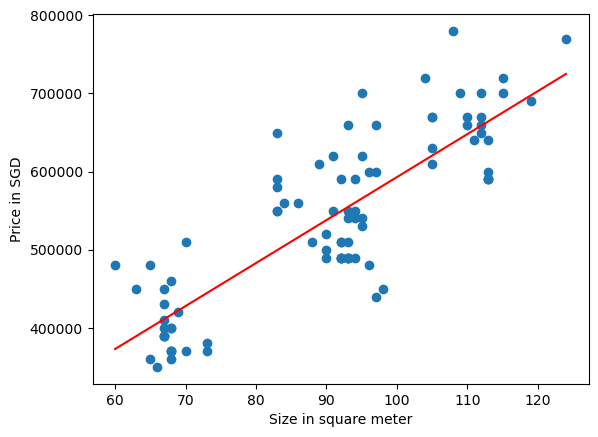

In [42]:
import matplotlib.pyplot as plt

area = X[:, 0].reshape((-1, 1))
predicted = get_prediction_linear_regression(area, y)
plt.scatter(area, y)
plt.plot(area, predicted, color = 'r')
plt.xlabel("Size in square meter")
plt.ylabel("Price in SGD")
plt.show()

## Gradient Descent

We will now learn to use gradient descent to approximate $\boldsymbol{w} = (w_0, w_1, \dots, w_n)$.

*Gradient descent*<sup>&#x2020;</sup> is an algorithm that minimizes the cost function by iteratively trying to
find the best parameters. In linear regression, we will try to minimize the Mean Squared
Error. The outline of the algorithm is as follows:
    
* Start with some $\boldsymbol{w} = (w_0, \dots, w_n)$
* Keep changing $w_0,\dots, w_n$ to minimize $J(\boldsymbol{w})$, where $J$ is our cost function

In this problem set, we will initially set $w_0, w_1, \dots, w_n$ to all be 0s. Then, we will set a
learning rate $\alpha$ that will affect the rate of change of $w_0, \dots, w_n$. Lastly, we will set
$N$ to specify the number of epochs of gradient descent we want to run.

The pseudo-code of Gradient Descent for linear regression is defined in Algorithm 1.

**Note**: In the following gradient descent-related tasks, calculate the value of the loss function *after* updating the bias and weights.

<sup>&#x2020;</sup> *The Gradient Descent algorithm is not limited to the linear regression model – it is a general optimisation technique and is also used in many other machine learning models such as Neural Networks.*

<figure>
<img src="imgs/mse_plot.png" alt="gradient descent" width="50%">
<figcaption style="text-align:center">Figure 3: Gradient descent tries to find parameters that lead to the lowest MSE.</figcaption>
</figure>

&nbsp;
<figure>
    <img src="imgs/grad_desc_algorithm.png" alt="gradient descent" width="80%">
</figure>

For MSE, The partial derivative $\frac{\partial J(\boldsymbol w)}{\partial w_i}$ with $m$ training samples can be derived as: 
$$
\frac{\partial J(\boldsymbol{w})}{\partial w_i} = \frac 1m\sum^m_{j=1}(h_w(x^{(j)})-y^{(j)})\cdot x_i^{(j)} 
$$
where $h_w$ is our hypothesis.

### Task 2.4: Gradient Descent on a single feature

Write the function `gradient_descent_one_variable(x, y, lr, number_of_epochs)` that
returns:

* $w_0$ - a number representing the bias constant
* $w_1$ - a number representing the weight constant
* $loss$ - a list that contains the MSE scores calculated during the gradient descent process.

The default value is $10^{-5}$ for `lr` and $250$ for `number_of_epochs`.

**Note**: You can use the `mean_squared_error` function for this task. (You do not need to re-define the function in Coursemology. However, you are free to do so if you explicitly want to use your own implementation of the function for this task.)

In [43]:
def gradient_descent_one_variable(x, y, lr = 1e-5, number_of_epochs = 250):
    '''
    Approximate bias and weight that gave the best fitting line.
    Parameters
    ----------
    x (np.ndarray) : (m, 1) numpy matrix representing a feature column
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    lr (float) : Learning rate
    number_of_epochs (int) : Number of gradient descent epochs
    
    Returns
    -------
        bias (float):
            The bias constant
        weight (float):
            The weight constant
        loss (list):
            A list where the i-th element denotes the MSE score at i-th epoch.
    '''
    # Do not change
    bias = 0
    weight = 0
    loss = []
    for _ in range(number_of_epochs):
        # TODO: add your solution here and remove `raise NotImplementedError`
        y_pred = bias + weight * x
        mse = mean_squared_error(y, y_pred)
       
        bias_gradient = np.mean(y_pred - y)
        weight_gradient = np.mean((y_pred - y) * x)
    
        bias -= lr * bias_gradient
        weight -= lr * weight_gradient
    
        loss.append(mse)
    
    return bias, weight, loss

In [44]:
area = X[:, 0].reshape((-1, 1))

loss_initial = gradient_descent_one_variable(area, y, lr = 1e-5, number_of_epochs = 250)[2][0]
loss_final = gradient_descent_one_variable(area, y, lr = 1e-5, number_of_epochs = 250)[2][-1]

assert loss_initial > loss_final

To check your work, plot the `loss` against `number_of_epochs` using the code snippet
below. It should be similar to Figure 4.

&nbsp;
<figure>
<img src="imgs/loss.png" alt="gradient descent" width="50%">
<figcaption style="text-align:center">Figure 4: MSE values decrease as the epoch number increases.</figcaption>
</figure>

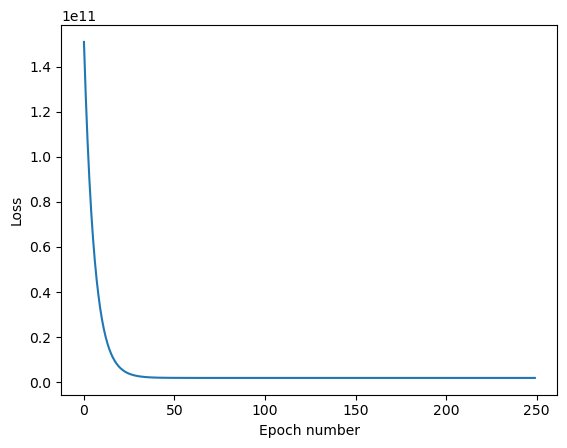

In [45]:
import matplotlib.pyplot as plt

area = X[:, 0].reshape((-1, 1))
b, w, loss = gradient_descent_one_variable(area, y, 1e-5, 250)
plt.plot([i for i in range(len(loss))], loss)
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

### Task 2.5: Gradient Descent on multiple features

Now, extend the code in Task 2.4 so it is able to find $w_0, w_1, \dots, w_n$ for multiple features. Write the function `gradient_descent_multi_variable(X, y, lr, number_of_epochs)` that returns:

* $w_0$ - a number representing the bias constant
* $w_1, w_2, \dots, w_n$ - $(n,1)$ NumPy matrix, where each element denotes the weight constant of a certain feature
* $loss$ - a list that contains the MSE scores calculated during the gradient descent process.

**Note**: You can use the `mean_squared_error` function for this task. (You do not need to re-define the function in Coursemology. However, you are free to do so if you explicitly want to use your own implementation of the function for this task.)

In [46]:
def gradient_descent_multi_variable(X, y, lr = 1e-5, number_of_epochs = 250):
    '''
    Approximate bias and weight that gave the best fitting line.
    Parameters
    ----------
    X (np.ndarray) : (m, n) numpy matrix representing feature matrix
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    lr (float) : Learning rate
    number_of_epochs (int) : Number of gradient descent epochs
    
    Returns
    -------
        bias (float):
            The bias constant
        weights (np.ndarray):
            A (n, 1) numpy matrix that specifies the weight constants.
        loss (list):
            A list where the i-th element denotes the MSE score at i-th epoch.
    '''
    # Do not change
    bias = 0
    weights = np.full((X.shape[1], 1), 0).astype(float)
    loss = []
    
    for _ in range(number_of_epochs):
        # TODO: add your solution here and remove `raise NotImplementedError`
        m, n = X.shape
        y_pred = X @ weights + bias
        
        bias_gradient = np.sum(y_pred - y) / m
        weights_gradient = np.sum(((y_pred - y) * X), axis = 0) / m
        weights_gradient = weights_gradient.reshape(weights.shape)
        
        bias = bias - lr * bias_gradient
        weights = weights - lr * weights_gradient
        
        y_pred = X @ weights + bias
        mse = mean_squared_error(y, y_pred)
        loss.append(mse)
        
    return bias, weights, loss

In [47]:
_, _, loss = gradient_descent_multi_variable(X, y, lr = 1e-5, number_of_epochs = 250)
loss_initial = loss[0]
loss_final = loss[-1]

assert loss_initial > loss_final

### Task 2.6: Which algorithm should we use for Linear Regression?

Compare the pros and cons of using normal equation and gradient descent for linear regression. Specifically:

- Compare the speed of the two algorithms on data with many features. 
- Compare the quality of the solutions obtained by the two algorithms. (i.e. how close to the optimal solution are the solutions obtained by the algorithms)
- Compare whether feature scaling is necessary for each algorithm to perform well.

Finally, select the algorithm you think is more suitable for this problemset and explain why you chose it.

<br></br>
Normal equation
<br></br>
Pros: 
1) it can find optimal parameters analytically
2) it does not require tuning learning rate
Cons: 
1) higher time complexity, which is O(mn^2) or O(n^3)
2) requires to calculate the inverse of (X^T * X), but sometimes the matrix is not invertible
<br></br>

Gradient descent
<br></br>
Pros:
1) it can handle large number of samples and has lower time complexity, O(kmn)
2) it handles collinearity better than normal equation
Cons:
1) it is an iterative process, require multiple iterations to converge to optimal solution
2) requires tuning the learning rate
3) requires features to be normalized

<br></br>
Since dataset is relatively small and normal equation finds the optimal parameters analytically, so normal equation is chosen.

## Part 3: Polynomial Regression

In real-world data, a straight line might not fit the data perfectly. Consider the relation between **schools** and **asking_price**.

&nbsp;
<figure>
<img src="imgs/school_price_rel.png" alt="school price relation" width="50%">
<figcaption style="text-align:center">Figure 5: Schools - Price Relationship.</figcaption>
</figure>

Houses with 0 schools nearby tend to be cheaper than houses with 1 school nearby. However, as the number of schools increases, the prices decrease. If we try a linear regression on the data, we obtain the following:

&nbsp;
<figure>
<img src="imgs/school_price_rel_linearfit.png" alt="school price relation linear fit" width="50%">
<figcaption style="text-align:center">Figure 5.1: Schools - Price Relationship With Linear Fit.</figcaption>
</figure>

Notice how we lose the detail that houses with 0 schools are actually cheaper than houses with 1 school nearby. A polynomial function can better capture this relationship:

&nbsp;
<figure>
<img src="imgs/school_price_rel_cubicfit.png" alt="school price relation cubic fit" width="50%">
<figcaption style="text-align:center">Figure 5.2: Schools - Price Relationship With Cubic Fit.</figcaption>
</figure>

A polynomial function is written as follows:

$$ y = w_0 + w_1 x + w_2 x^2 + ... + w_n x^n $$

where $y$ is the target value, $x$ is a (*single*) feature value, and $n$ is the degree of the polynomial. $w_0$ is the bias term and $w_1, \dots, w_n$ are the feature weights. 

Notice how if we set $x_1 = x, x_2 = x^2, \dots, x_n = x^n$. The polynomial function is simply linear regression with $n$ features:

$$ y = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n x_n $$

### Task 3.1 : Create Polynomial Matrix

Write the function `create_polynomial_matrix(X, power)` that takes a $(m, 1)$-matrix and an
integer, and returns a polynomial matrix with shape $(m, power)$.

$$
\left[\begin{array}{cc} 
1\\
2\\
3
\end{array}\right]
\xrightarrow[]{\text{create_polynomial_matrix(3)}}
\left[\begin{array}{cc} 
1 & 1^2 & 1^3\\ 
2 & 2^2 & 2^3\\
3 & 3^2 & 3^3
\end{array}\right]
\rightarrow
\left[\begin{array}{cc} 
1 & 1 & 1\\ 
2 & 4 & 8\\
3 & 9 & 27
\end{array}\right]
$$ 
**Hint**: Consider using `np.tile`/`np.repeat` together with `np.cumprod`/`np.power`.

In [48]:
def create_polynomial_matrix(X, power = 2):
    '''
    Create a polynomial matrix.
    
    Parameters
    ----------
    X: (m, 1) numpy matrix
    Returns
    -------
        A (m, power) numpy matrix where the i-th element denotes
            X raised to the power of i.
    '''
    # TODO: add your solution here and remove `raise NotImplementedError`
    X = np.tile(X, (1,power))
    X = np.cumprod(X, axis = 1)
    return X

In [49]:
vector = np.array([[1], [2], [3]])
poly_matrix = np.array([[1, 1, 1], [2, 4, 8], [3, 9, 27]])

assert np.array_equal(create_polynomial_matrix(vector, 3), poly_matrix)

### Task 3.2: Get the prediction line

Write the function `get_prediction_poly_regression(X, y, power, include_bias)` that returns
`y_pred`, a vector of predicted values for the training data.

**Note**: You can use the functions `create_polynomial_matrix` and `get_prediction_linear_regression` from before for this task. (You do not need to re-define the functions in Coursemology. However, you are free to do so if you explicitly want to use your own implementation of the functions for this task.)

In [50]:
def get_prediction_poly_regression(X, y, power = 2, include_bias = True):
    '''
    Calculate the best polynomial line.
    Parameters
    ----------
    X (np.ndarray) : (m, 1) numpy matrix representing feature matrix
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    power (int) : Specify the degree of the polynomial
    include_bias (boolean) : Specify whether to use bias term
    Returns
    -------
        A (m, 1) numpy matrix representing prediction values.
    '''
    # TODO: add your solution here and remove `raise NotImplementedError`
    polynomial_matrix = create_polynomial_matrix(X, power)
    if include_bias:
        polynomial_matrix = np.hstack((np.ones((polynomial_matrix.shape[0], 1)), polynomial_matrix))
    coefficients = np.linalg.lstsq(polynomial_matrix, y, rcond=None)[0]
    predictions = polynomial_matrix @ coefficients
    return predictions

In [51]:
test_X, test_y = np.arange(3).reshape((-1, 1)), np.arange(4, 7).reshape((-1, 1))
pred_y = get_prediction_poly_regression(test_X, test_y, 2)

assert round(mean_squared_error(test_y, pred_y), 5) == 0

To check your work, create a polynomial regression model, using `power = 3` and `include_bias = True`, with **schools** as the only feature and **asking_price** as the target value. Plot your prediction line using the code snippet below. It should look similar to Figure 6.

&nbsp;
<figure>
<img src="imgs/poly_reg.png" alt="polynomial regression" width="50%">
    <figcaption style="text-align:center">Figure 6: Example of polynomial regression using <b>schools</b> as feature.</figcaption>
</figure>

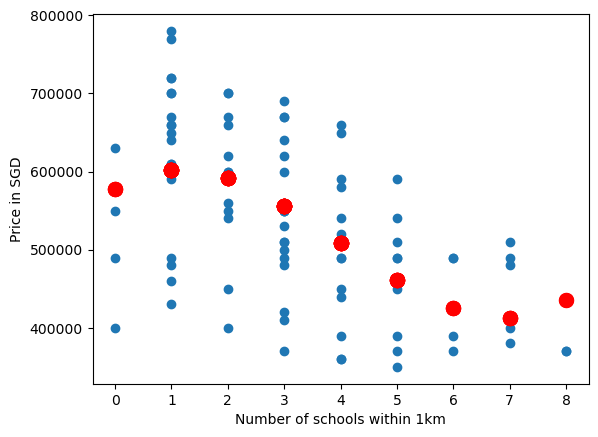

In [52]:
import matplotlib.pyplot as plt

schools = X[:, 2].reshape((-1, 1))
predicted = get_prediction_poly_regression(schools, y, 3)
plt.scatter(schools, y)
plt.scatter(schools, predicted, color = 'r', s = 100)
plt.xlabel("Number of schools within 1km")
plt.ylabel("Price in SGD")
plt.show()

### Task 3.3: Feature Scaling

As we create a higher degree polynomial matrix, each column will have a larger scale
than the previous one. This can lead to poor performance for gradient descent. Here
is where feature scaling plays an important role. Write the function `feature_scaling(X)`
that takes a NumPy matrix `X` and returns a mean-normalized matrix.

**Note**: The normalization occurs on the column level (i-th column is normalized by the
mean and standard deviation of the i-th column). That is,

$$
\text{If} \quad \boldsymbol{v} = \begin{pmatrix} v_1 \\ v_2 \\ \vdots \\ v_k \end{pmatrix} \\
\boldsymbol{v}_{norm} = \frac{\boldsymbol{v} - \boldsymbol{\hat{v}}}{\sigma_{v}}
$$

where $\boldsymbol{v}$ is a vector of $k$ elements, $\boldsymbol{\hat{v}}$ is its mean, and $\sigma_{v}$ is its standard deviation.

$$
\left[\begin{array}{cc} 
1 & 133\\
4 & 700\\
5 & 133\\
8 & 700
\end{array}\right]
\xrightarrow[]{\text{feature_scaling}}
\left[\begin{array}{cc} 
-1.4 & -1\\
-0.2 & 1\\
0.2 & -1\\
1.4 & 1
\end{array}\right]
$$ 

Focusing on the first feature:

$$
\boldsymbol{v} = \left(\begin{array}{cc}
1\\
4\\
5\\
8
\end{array}\right), \boldsymbol{\hat{v}} = 4.5, \sigma_{v} = 2.5$$

$$\boldsymbol{v}_{norm} = \frac{\boldsymbol{v} - 4.5}{2.5} = \left(\begin{array}{cc}
-1.4\\
-0.2\\
0.2\\
1.4
\end{array}\right)
$$

**Hint**: Consider using `np.mean()` and `np.std()`.

In [53]:
def feature_scaling(X):
    '''
    Mean normalized each feature column.
    Parameters
    ----------
    X (np.ndarray) : (m, n) numpy matrix representing feature matrix
    Returns
    -------
        A (m, n) numpy matrix where each column has been mean-normalized.
    '''
    # TODO: add your solution here and remove `raise NotImplementedError`
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    return (X - mean) / std

In [54]:
public_X = np.array([[1, 133], [4, 700], [5, 133], [8, 700]])
expected = np.array([[-1.4, -1], [-0.2, 1], [0.2, -1], [1.4, 1]])

assert np.array_equal(feature_scaling(public_X), expected)

### Task 3.4: Find number of epochs to converge

Fill in the function `find_number_of_epochs(X, y, lr, delta_loss)` that that returns:

* $w_0$ - a number representing the bias constant
* $w_1, w_2, \dots, w_n$ - $(n, 1)$ NumPy matrix, where each element denotes the weight constant of a certain feature
* $num\_of\_epochs$ - a number representing the number of epochs performed to reach convergence

We define a single epoch as performing gradient descent *once* and calculating the loss. The loss calculation and gradient descent should be performed using MSE.

The definition of convergence is as follows:

$$ |J_{t-1} - J_{t}| < delta\_loss $$

where $J_{t-1}$ is loss at timestep $t-1$ (previous timestep), $J_{t}$ is loss at timestep $t$ (current timestep), and $delta\_loss$ is the termination criterion. 

In [55]:
def find_number_of_epochs(X, y, lr, delta_loss):
    '''
    Do gradient descent until convergence and return number of epochs
    required.
    Parameters
    ----------
    X (np.ndarray) : (m, n) numpy matrix representing feature matrix
    y (np.ndarray) : (m, 1) numpy matrix representing target values
    lr (float) : Learning rate
    delta_loss (float) : Termination criterion
    
    Returns
    -------
        bias (float):
            The bias constant
        weights (np.ndarray):
            A (n, 1) numpy matrix that specifies the weight constants.
        num_of_epochs (int):
            Number of epochs to reach convergence.
        current_loss (float):
            The loss value obtained after convergence.
    '''
    # Do not change
    bias = 0
    weights = np.full((X.shape[1], 1), 0).astype(float)
    num_of_epochs = 0
    previous_loss = 1e14
    current_loss = -1e14
    while abs(previous_loss - current_loss) >= delta_loss:
        # TODO: add your solution here and remove `raise NotImplementedError`
        m, n = X.shape
        y_pred = X @ weights + bias
        previous_loss = mean_squared_error(y, y_pred)
        bias_gradient = np.sum(y_pred - y) / m
        weights_gradient = np.sum(((y_pred - y) * X), axis = 0) / m
        weights_gradient = weights_gradient.reshape(weights.shape)
        bias = bias - lr * bias_gradient
        weights = weights - lr * weights_gradient
        y_pred = X @ weights + bias
        current_loss = mean_squared_error(y, y_pred)
        num_of_epochs += 1
    
    return bias, weights, num_of_epochs, current_loss

In [56]:
poly_X = create_polynomial_matrix(X[:, 2].reshape((-1, 1)), 3)
_, _, num_of_epochs, _ = find_number_of_epochs(poly_X, y, 1e-5, 1e7)

assert num_of_epochs > 0

### Task 3.5: Analyze the effects of feature scaling on Gradient Descent

For this task, take the **schools** column and transform it into a 3rd-degree polynomial matrix. 
We will use this as our feature matrix.

**Tabulate and list** the number of epochs taken to reach convergence for at least **3 different learning rates** using the `find_number_of_epochs` function in Task 3.4. 
Do the same on the mean-normalized polynomial matrix. We suggest using learning rate values from **1e-5 to 1** and feel free to use any other values that help with your observation.

Compare the **number of epochs** taken between **normalized** and **non-normalized polynomial matrices**.
What can you conclude from this observation?

In [ ]:
X = create_polynomial_matrix(schools)

# not normalized
x1, x2, x3 = find_number_of_epochs(X, y, 1e-5, 1e7)[2], find_number_of_epochs(X, y, 0.01, 1e7)[2], find_number_of_epochs(X, y, 1, 1e7)[2]

print('non normalized num_iterations:')
print(x1, x2, x3)

# normalized 
X_norm = feature_scaling(X)
x1, x2, x3 = find_number_of_epochs(X_norm, y, 1e-5, 1e7)[2], find_number_of_epochs(X_norm, y, 0.01, 1e7)[2], find_number_of_epochs(X_norm, y, 1, 1e7)[2]
print('normalized num_iterations:')
print(x1, x2, x3)

**1e-5 learning rate**\
non normalized num_iterations:\
496\
normalized num_iterations:\
1

**0.01 learning rate**\
non normalized num_iterations:\
296\
normalized num_iterations:\
283

**1 learning rate**\
non normalized num_iterations:\
58\
normalized num_iterations:\
31
<br></br>
The number of epochs taken from normalized polynomial matrices is less than non-normalized polynomial matrices. The gradients for normalized inputs are smaller than those for non-normalized inputs. Hence, gradient descent is more stable, and reduces the chance of the model "overshooting" the local minima, so it converges faster. We can conclude that mean-normalizing polynomial matrices can improve the convergence speed of gradient descent.

## Submission

Once you are done, please submit your work to Coursemology, by copying the right
snippets of code into the corresponding box that says “Your answer,” and click “Save.”
After you save, you can still make changes to your submission.

Once you are satisfied with what you have uploaded, click “Finalize submission.” Note
that once your submission is finalized, it is considered to be submitted for grading
and cannot be changed. If you need to undo this action, you will have to email your
assigned tutor for help. Please do not finalize your submission until you are sure that
you want to submit your solutions for grading.